# Eulerian Path Algorithm - Visualization Demo
This notebook visualizes the steps of converting a curve image into a graph.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path to find 'src'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import cv2
import networkx as nx
from src.image_processor import ImageProcessor
from src.graph_builder import GraphBuilder
from src.eulerian_logic import EulerianPathFinder
from src.path_generator import PathGenerator
from src.eulerian_walker import AngularWalker

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Input Selection
Choose whether to use the synthetic "Square with Slash" example or a custom file.
Set `USE_CUSTOM_FILE = True` and provide `CUSTOM_FILE_PATH` to use your own image.

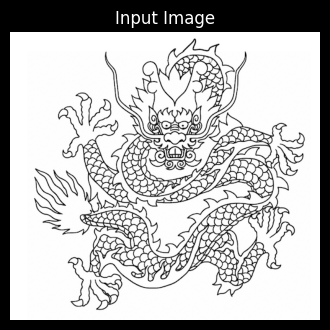

In [2]:
# --- CONFIGURATION ---
USE_CUSTOM_FILE = True
CUSTOM_FILE_PATH = "../samples/dragon.png" # Replace with your file path
# ---------------------

if USE_CUSTOM_FILE and os.path.exists(CUSTOM_FILE_PATH):
    print(f"Loading custom file: {CUSTOM_FILE_PATH}")
    # Load image using OpenCV to get array
    img = cv2.imread(CUSTOM_FILE_PATH, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error loading file. Falling back to synthetic example.")
        USE_CUSTOM_FILE = False
else:
    if USE_CUSTOM_FILE:
        print(f"File not found: {CUSTOM_FILE_PATH}. Using synthetic example.")
    
    # Create a 200x200 white image (Synthetic)
    img = np.full((200, 200), 255, dtype=np.uint8)

    # Define points
    tl = (20, 20)
    tr = (180, 20)
    br = (180, 180)
    bl = (20, 180)

    thickness = 5
    color = (0)

    # Draw Square
    cv2.line(img, tl, tr, color, thickness)
    cv2.line(img, tr, br, color, thickness)
    cv2.line(img, br, bl, color, thickness)
    cv2.line(img, bl, tl, color, thickness)

    # Draw Diagonal (Slash) -> Top-Left to Bottom-Right
    cv2.line(img, tl, br, color, thickness)
    
    print("Generated Synthetic Square with Slash")

plt.figure(figsize=(4,4))
plt.title("Input Image")
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

## 2. Process & Skeletonize

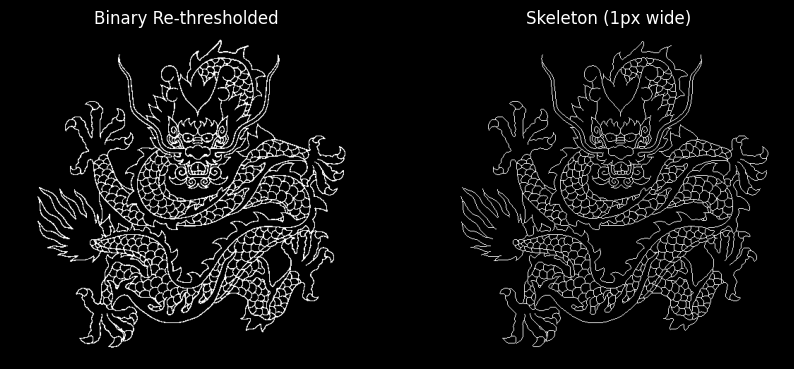

In [3]:
processor = ImageProcessor(image_array=img)
binary = processor.preprocess()
skeleton = processor.get_skeleton()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(binary, cmap='gray')
axes[0].set_title("Binary Re-thresholded")
axes[0].axis('off')

axes[1].imshow(skeleton, cmap='gray')
axes[1].set_title("Skeleton (1px wide)")
axes[1].axis('off')
plt.show()

## 3. Build Graph
Extract nodes (red) and edges (multicolored) from the skeleton. We also apply `merge_close_nodes` to fix pixel-cluster junctions.

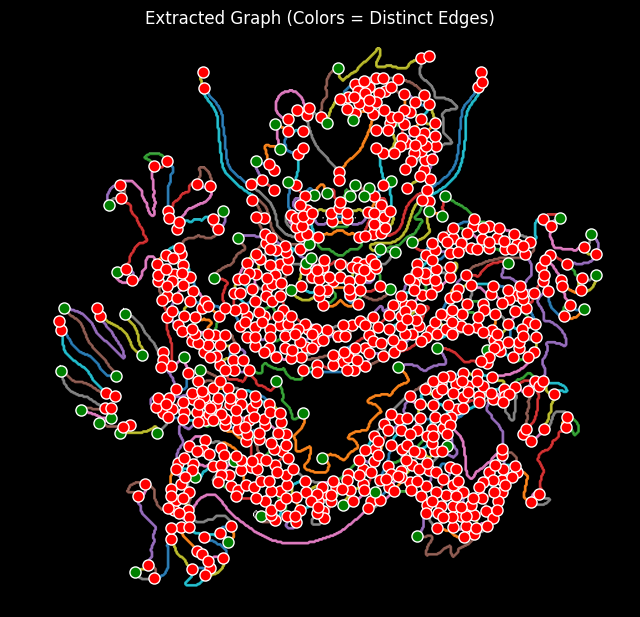

In [4]:
builder = GraphBuilder(skeleton)
G = builder.build_graph()

if hasattr(builder, 'merge_close_nodes'):
    builder.merge_close_nodes(distance_threshold=5.0)
builder.prune_graph(min_path_length=10)
G = builder.graph

# Visualization Code
plt.figure(figsize=(8,8))
plt.imshow(skeleton, cmap='gray')
cmap = plt.get_cmap('tab10')

for i, (u, v, data) in enumerate(G.edges(data=True)):
    path = data.get('path')
    color = cmap(i % 10)
    if path:
        path = np.array(path)
        plt.plot(path[:,1], path[:,0], '-', color=color, linewidth=2, alpha=0.9, label=f"Edge {i}")
    else:
        plt.plot([u[1], v[1]], [u[0], v[0]], '-', color=color, linewidth=2, alpha=0.9)

for node in G.nodes():
    y, x = node
    degree = G.degree(node)
    color = 'r' if degree != 2 else 'g' 
    plt.plot(x, y, 'o', color=color, markersize=8, markeredgecolor='white')

plt.title("Extracted Graph (Colors = Distinct Edges)")
plt.axis('off')
plt.show()

## 4. Path Optimization Comparison
We compare the Basic (Random) Eulerian Path vs the Optimized (Angular) Path.

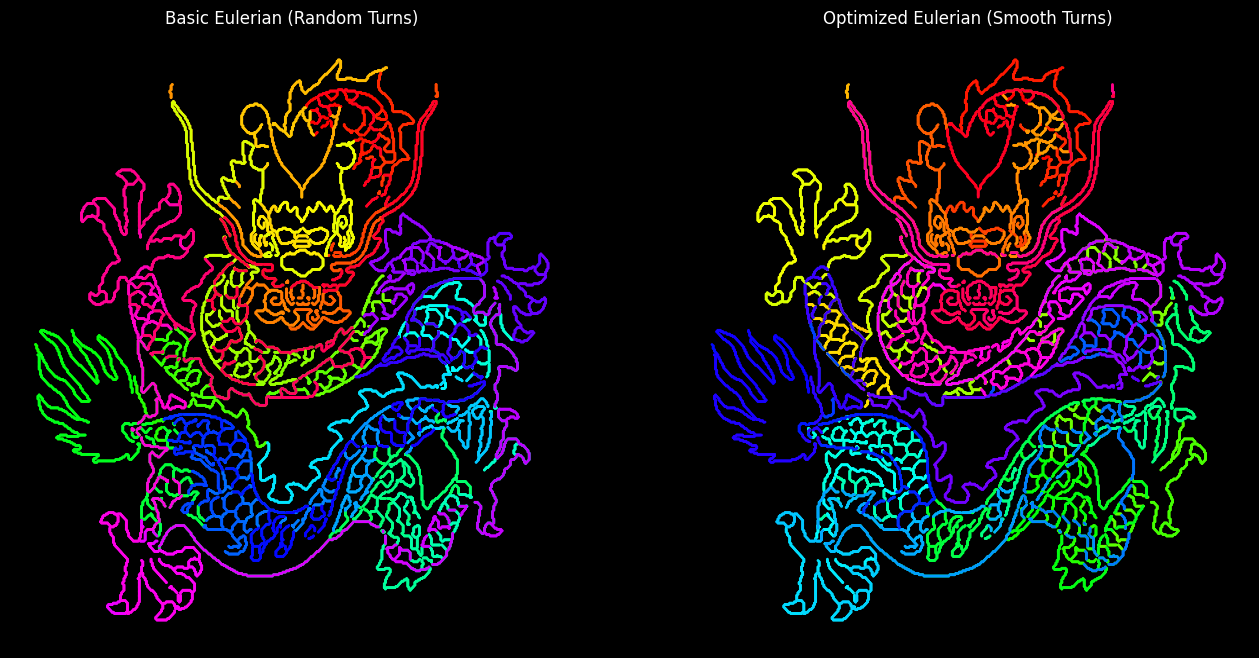

In [5]:
euler_finder = EulerianPathFinder(G)
print(f"Initial Analysis: {euler_finder.analyze().upper()}")

G_final = euler_finder.make_eulerian(force_double_wall=False)
print(f"Final Graph Edges: {len(G_final.edges())}")

# 1. Basic Path (Random)
# We manually trigger the basic implementation (bypassing AngularWalker)
# By using nx.eulerian_path directly on the Multigraph
# Note: Need to handle 'keys' manually as we did in v1 of PathGenerator
def basic_random_walk(graph):
    edges = list(nx.eulerian_path(graph, keys=True))
    pixels = []
    for u, v, k in edges:
        data = graph[u][v][k]
        seg = data.get('path', [u,v])
        # Simple direction check
        dist_end = np.sum((np.array(seg[-1]) - u)**2)
        if dist_end < np.sum((np.array(seg[0]) - u)**2):
            seg = seg[::-1]
        pixels.extend(seg)
    return pixels

basic_path = basic_random_walk(G_final)

# 2. Optimized Path (Angular Walker)
walker = AngularWalker(G_final)
optimized_path = walker.find_path()

full_path_arr = np.array(optimized_path)

# Visualize Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Basic
axes[0].set_title("Basic Eulerian (Random Turns)")
path_arr_1 = np.array(basic_path)
# Color by progress
axes[0].scatter(path_arr_1[:, 1], path_arr_1[:, 0], c=np.linspace(0, 1, len(path_arr_1)), cmap='hsv', s=1)
axes[0].invert_yaxis()
axes[0].axis('off')

# Plot Optimized
axes[1].set_title("Optimized Eulerian (Smooth Turns)")
path_arr_2 = np.array(optimized_path)
axes[1].scatter(path_arr_2[:, 1], path_arr_2[:, 0], c=np.linspace(0, 1, len(path_arr_2)), cmap='hsv', s=1)
axes[1].invert_yaxis()
axes[1].axis('off')

plt.show()

## 5. Animation (Optimized Path)
Visualizing the printer nozzle movement.

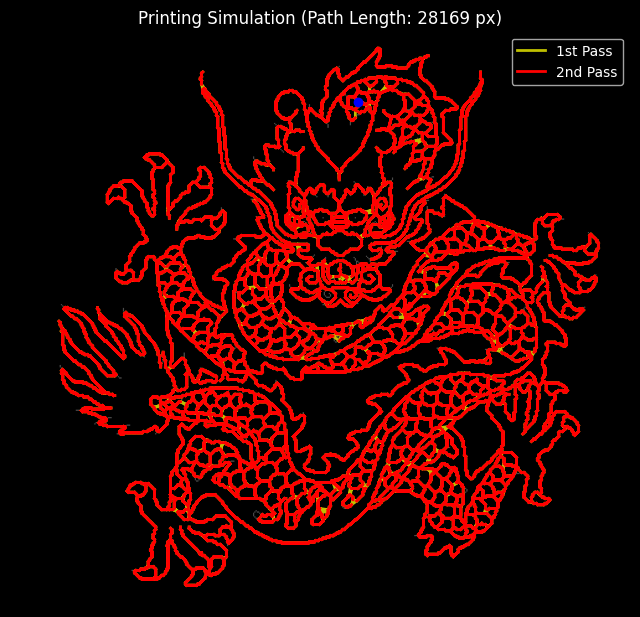

In [7]:
plt.rcParams['animation.embed_limit'] = 100.0
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(skeleton, cmap='gray', alpha=0.3)
ax.set_title(f"Printing Simulation (Path Length: {len(full_path_arr)} px)")
ax.axis('off')

# Edge coloring logic (Yellow=1st visit, Red=2nd)
edge_visits = {}
segment_colors = []
for i in range(len(full_path_arr) - 1):
    p1 = tuple(full_path_arr[i])
    p2 = tuple(full_path_arr[i+1])
    edge_key = tuple(sorted((p1, p2)))
    cnt = edge_visits.get(edge_key, 0)
    edge_visits[edge_key] = cnt + 1
    segment_colors.append(1 if cnt > 0 else 0)

# OPTIMIZATION: Reduce target frames to keep file size small
# Default matplotlib limit is approx ~20MB for embedded HTML.
# 800 frames * (plot overhead) can exceed this for complex lines.
target_frames = 400 # Reduced from 800
total_points = len(full_path_arr)

if total_points > target_frames:
    step = total_points // target_frames
else:
    step = 1

print(f"Total Points: {total_points}. Subsampling Step: {step}. Frames: {total_points // step}")

sim_path = full_path_arr[::step]

# Pre-construct segments mapped to reduced frames
import numpy as np
line_y, = ax.plot([], [], 'y-', linewidth=2, label='1st Pass')
line_r, = ax.plot([], [], 'r-', linewidth=2, label='2nd Pass')
point, = ax.plot([], [], 'bo', markersize=6)
ax.legend(loc='upper right')

y_x, y_y = [], []
r_x, r_y = [], []
frame_map_y = [0] * len(sim_path)
frame_map_r = [0] * len(sim_path)

curr_y_len = 0
curr_r_len = 0

for i in range(len(full_path_arr) - 1):
    frame_idx = i // step
    if frame_idx >= len(sim_path): break
    
    p1 = full_path_arr[i]
    p2 = full_path_arr[i+1]
    color_code = segment_colors[i]
    
    if color_code == 0: # Yellow
        y_x.extend([p1[1], p2[1], np.nan])
        y_y.extend([p1[0], p2[0], np.nan])
        curr_y_len += 3
    else: # Red
        r_x.extend([p1[1], p2[1], np.nan])
        r_y.extend([p1[0], p2[0], np.nan])
        curr_r_len += 3
        
    frame_map_y[frame_idx] = curr_y_len
    frame_map_r[frame_idx] = curr_r_len

# Forward fill lengths
for k in range(len(frame_map_y)):
    if frame_map_y[k] == 0 and k > 0: frame_map_y[k] = frame_map_y[k-1]
    if frame_map_r[k] == 0 and k > 0: frame_map_r[k] = frame_map_r[k-1]

full_y_x = np.array(y_x)
full_y_y = np.array(y_y)
full_r_x = np.array(r_x)
full_r_y = np.array(r_y)

def init():
    line_y.set_data([], [])
    line_r.set_data([], [])
    point.set_data([], [])
    return line_y, line_r, point

def update(frame):
    len_y = frame_map_y[frame]
    len_r = frame_map_r[frame]
    line_y.set_data(full_y_x[:len_y], full_y_y[:len_y])
    line_r.set_data(full_r_x[:len_r], full_r_y[:len_r])
    if frame < len(sim_path):
       point.set_data([sim_path[frame, 1]], [sim_path[frame, 0]])
    return line_y, line_r, point

# Lower interval to keep animation snappy despite fewer frames
interval = 40 
ani = animation.FuncAnimation(fig, update, frames=len(sim_path), init_func=init, blit=True, interval=interval)
HTML(ani.to_jshtml())